Compiling model...
Building feed-forward neural network...
'build' took 0.099351 s

'compile' took 1.301919 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.19e-03, 2.50e+05, 8.85e+04, 8.87e+04]    [1.08e-03, 2.50e+05, 8.85e+04, 8.87e+04]    []  
1000      [2.06e-03, 2.17e+05, 6.96e+04, 6.96e+04]    [3.33e-05, 2.17e+05, 6.96e+04, 6.96e+04]    []  
2000      [1.64e-04, 1.94e+05, 5.69e+04, 5.70e+04]    [2.50e-06, 1.94e+05, 5.69e+04, 5.70e+04]    []  
3000      [3.03e-05, 1.73e+05, 4.59e+04, 4.59e+04]    [4.53e-07, 1.73e+05, 4.59e+04, 4.59e+04]    []  
4000      [7.84e-06, 1.54e+05, 3.61e+04, 3.61e+04]    [1.16e-07, 1.54e+05, 3.61e+04, 3.61e+04]    []  
5000      [2.43e-06, 1.36e+05, 2.77e+04, 2.77e+04]    [3.56e-08, 1.36e+05, 2.77e+04, 2.77e+04]    []  
6000      [8.46e-07, 1.19e+05, 2.04e+04, 2.04e+04]    [1.23e-08, 1.19e+05, 2.04e+04, 2.04e+04]    []  
7000      [3.21e-07, 1.03e+05, 1.43e+04

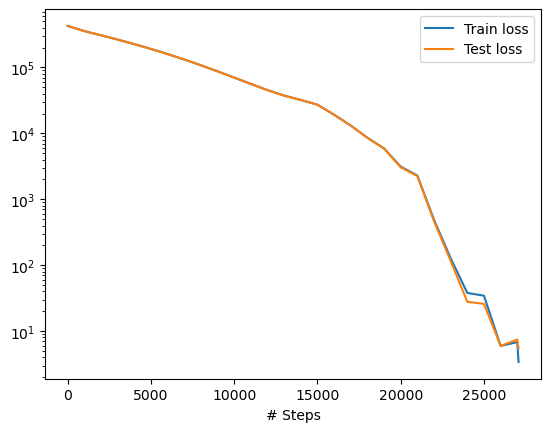

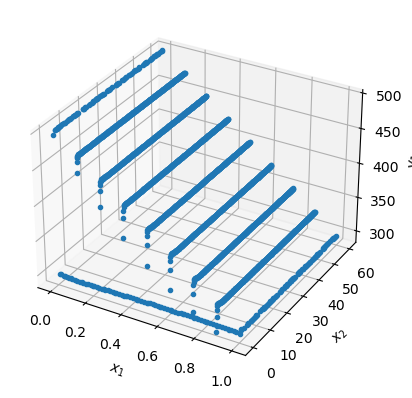

In [7]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random as python_random

np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Problem parameters
a = 1    # Thermal diffusivity
L = 1    # Length of the interval

# PDE residual
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t - a * du_xx

# Computational geometry: Interval x TimeDomain
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 60)    # time domain from 0 to 1
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Boundary conditions
def boundary_r (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)
def boundary_l (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)


# Boundary conditions:
bc_l = dde.DirichletBC(geomtime, lambda x: 500, boundary_l)                #Dirichlet (constant temperature)
bc_r = dde.DirichletBC(geomtime, lambda x: 298, boundary_r)                #Dirichlet (constant temperature)
ic = dde.IC(geomtime, lambda x: 298, lambda _, on_initial: on_initial)

# Data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l,bc_r, ic],
    num_domain=2540,
    num_boundary=200,
    num_initial=80,
    num_test=2540,
)

# Neural network
layer_size = [2] + [25] * 3 + [1]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Model
model = dde.Model(data, net)

# Compile and train
model.compile("adam", lr=1e-3)
model.train(iterations=27000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Plot results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [ ]:
# Test set
x = np.linspace(0, L, 250)  # 100 points along the length
specific_time = 1         # time 
test_set = np.array([[xi, specific_time] for xi in x])

# Making predictions
y_pred = model.predict(test_set)
temperature_pred = y_pred[:, 0]  

# Plotting the temperature distribution
plt.figure(figsize=(10, 6))
plt.plot(x, temperature_pred, label='Predicted Temperature')
plt.xlabel('Position along the length (L)')
plt.ylabel('Temperature')
plt.title('Temperature Distribution at Time = 1')
plt.legend()
plt.show()

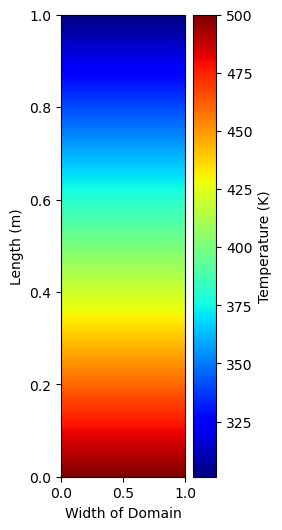

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose `model` has been trained and `L` is the length of the domain.
# Generate a grid of points along the length
x = np.linspace(0, L, 256)
t = np.full_like(x,1)  # for t = 15 minutes, converted to seconds
X = np.vstack((x, t)).T

# Predict the temperature distribution using the trained model
u_pred = model.predict(X)

# Plot the results
plt.figure(figsize=(2, 6))
plt.imshow(u_pred.reshape((256, 1)), extent=[0, L, 0, 1], origin="lower", aspect="auto",cmap='jet')
plt.colorbar(label='Temperature (K)')
#plt.title("Temperature Distribution at t = 15 min")
plt.xlabel("Width of Domain")
plt.ylabel("Length (m)")
plt.show()


In [9]:
u_pred.min()

301.27417

In [10]:
u_pred.max()

500.01062

In [6]:
print(u_pred)

[[491.82828]
 [491.1421 ]
 [490.4563 ]
 [489.77087]
 [489.0854 ]
 [488.3994 ]
 [487.71283]
 [487.02548]
 [486.3374 ]
 [485.64877]
 [484.95953]
 [484.26993]
 [483.5799 ]
 [482.88953]
 [482.19882]
 [481.50772]
 [480.81625]
 [480.12448]
 [479.4323 ]
 [478.73972]
 [478.0468 ]
 [477.35352]
 [476.65997]
 [475.96625]
 [475.2723 ]
 [474.57825]
 [473.88416]
 [473.19012]
 [472.49622]
 [471.80243]
 [471.10892]
 [470.41565]
 [469.72278]
 [469.03027]
 [468.33823]
 [467.64655]
 [466.95535]
 [466.26468]
 [465.57437]
 [464.8846 ]
 [464.19534]
 [463.50647]
 [462.81802]
 [462.13004]
 [461.44235]
 [460.7551 ]
 [460.0681 ]
 [459.38144]
 [458.695  ]
 [458.00882]
 [457.3229 ]
 [456.63712]
 [455.9515 ]
 [455.26602]
 [454.5806 ]
 [453.8953 ]
 [453.21002]
 [452.52475]
 [451.83957]
 [451.15433]
 [450.46915]
 [449.78387]
 [449.0986 ]
 [448.41327]
 [447.7279 ]
 [447.04248]
 [446.35693]
 [445.6714 ]
 [444.98572]
 [444.30005]
 [443.6143 ]
 [442.92847]
 [442.2426 ]
 [441.55664]
 [440.8706 ]
 [440.18448]
 [439.49835]

Compiling model...
Building feed-forward neural network...
'build' took 0.031545 s

'compile' took 0.479308 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.70e-03, 2.50e+05, 8.90e+04, 8.88e+04]    [3.04e-03, 2.50e+05, 8.90e+04, 8.88e+04]    []  
1000      [1.03e-03, 2.19e+05, 7.08e+04, 7.09e+04]    [2.01e-05, 2.19e+05, 7.08e+04, 7.09e+04]    []  
2000      [7.88e-05, 1.96e+05, 5.81e+04, 5.81e+04]    [1.46e-06, 1.96e+05, 5.81e+04, 5.81e+04]    []  
3000      [1.43e-05, 1.75e+05, 4.69e+04, 4.69e+04]    [2.61e-07, 1.75e+05, 4.69e+04, 4.69e+04]    []  
4000      [3.67e-06, 1.56e+05, 3.70e+04, 3.70e+04]    [6.63e-08, 1.56e+05, 3.70e+04, 3.70e+04]    []  
5000      [1.14e-06, 1.37e+05, 2.84e+04, 2.84e+04]    [2.03e-08, 1.37e+05, 2.84e+04, 2.84e+04]    []  
6000      [3.97e-07, 1.21e+05, 2.11e+04, 2.11e+04]    [6.98e-09, 1.21e+05, 2.11e+04, 2.11e+04]    []  
7000      [1.51e-07, 1.05e+05, 1.49e+04

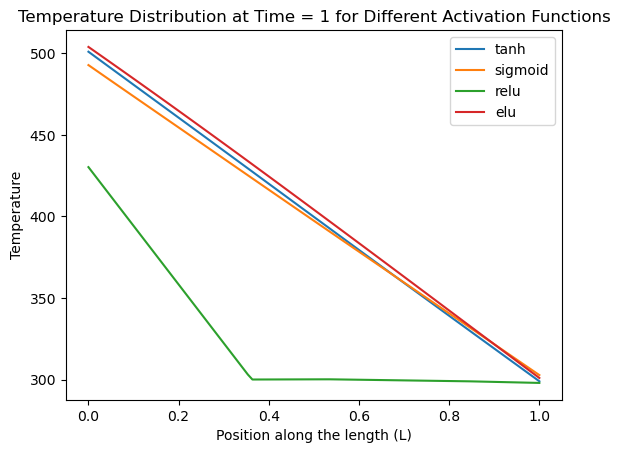

In [15]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random as python_random

np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Problem parameters
a = 1    # Thermal diffusivity
L = 1    # Length of the interval

# PDE residual
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return du_t - a * du_xx

# Computational geometry: Interval x TimeDomain
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 60)    # time domain from 0 to 1
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Boundary conditions
def boundary_r (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)
def boundary_l (x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0)

bc_l = dde.DirichletBC(geomtime, lambda x: 500, boundary_l)  # Dirichlet (constant temperature)
bc_r = dde.DirichletBC(geomtime, lambda x: 298, boundary_r)  # Dirichlet (constant temperature)
ic = dde.IC(geomtime, lambda x: 298, lambda _, on_initial: on_initial)

# Data
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, ic],
    num_domain=2540,
    num_boundary=200,
    num_initial=80,
    num_test=2540,
)

# Define a list of activation functions
activation_functions = ["tanh", "sigmoid", "relu", "elu"]

# For storing model outputs
model_outputs = []

# X values for plotting
x_values = np.linspace(0, L, 100)
# Time at which to evaluate the model
t_value = 1

# Loop over activation functions to train models and collect outputs
for activation in activation_functions:
    # Define the neural network
    layer_size = [2] + [25] * 3 + [1]
    initializer = "Glorot normal"
    net = dde.nn.FNN(layer_size, activation, initializer)
    
    # Define the model
    model = dde.Model(data, net)
    
    # Compile and train the model (use fewer iterations for a quick test)
    model.compile("adam", lr=1e-3)
    losshistory, _ = model.train(epochs=27000)  # Use a smaller number like 1000 for a quick test
    
    # Create an array for the whole domain at t = 1 and predict
    X = np.vstack((x_values, np.full_like(x_values, t_value))).T
    y_pred = model.predict(X)
    
    # Store the predicted results for plotting
    model_outputs.append(y_pred.flatten())

# Plot the results for different activation functions
for i, activation in enumerate(activation_functions):
    plt.plot(x_values, model_outputs[i], label=activation)

plt.xlabel('Position along the length (L)')
plt.ylabel('Temperature')
plt.title('Temperature Distribution at Time = 1 for Different Activation Functions')
plt.legend()
plt.show()
